In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import glob
from tqdm import tqdm_notebook as tqdm
import reverse_geocoder as rg
import os,sys
import tables
# path = os.path.abspath("/Users/adityasalian/Desktop/Livin-the-dream/spring-2023/CS-7641/Project/Ada-master/Project")
# sys.path.append(path)
import hdf5_getters
import matplotlib.pyplot as plt
import seaborn as sns
# from map_helpers import *
from data_helpers import *
from analysis_helpers import *
from map_helpers import *
from plot_helper import *
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.manifold import TSNE
import matplotlib
%matplotlib inline

In [2]:
# h5filename = "/Users/adityasalian/Desktop/Livin-the-dream/spring-2023/CS-7641/Project/MillionSongSubset/A/A/A/TRAAAAW128F429D538.h5"
# a = tables.open_file(h5filename, mode='r')

In [3]:
def open_h5_file_read(h5filename):
    """
    Open an existing H5 in read mode.
    Same function as in hdf5_utils, here so we avoid one import
    """
    return tables.open_file(h5filename, mode='r')

def load_song_data(letter, half):
    assert half in [1,2], 'half must be one or two'
    path = PATH_R
    categories = get_total_features()
    data = []
    file_paths = glob.glob(path+'/'+letter+'/'+regex_half[half]+'/*/*.h5')

    for file_path in tqdm(file_paths):
        h5file = open_h5_file_read(file_path)
        datapoint = {}
        for cat in categories:
            datapoint[cat] = getattr(hdf5_getters, "get_"+cat)(h5file)
        h5file.close()
        data.append(datapoint)

    df = pd.DataFrame(data)
    return df


def get_total_features():

    #Load the features name from the metadata into a list so that we don't have to insert them manually

    h5_summary = open_h5_file_read(PATH_hdf5)

    metadata = h5_summary.get_node('/metadata/songs/').colnames
    metadata.remove('genre')
    metadata.remove('analyzer_version')
    metadata = [w.replace('idx_', '') for w in metadata]

    analysis = h5_summary.get_node('/analysis/songs/').colnames
    analysis = [w.replace('idx_', '') for w in analysis]

    musicbrainz = h5_summary.get_node('/musicbrainz/songs/').colnames
    musicbrainz = [w.replace('idx_', '') for w in musicbrainz]

    total_features = np.array(metadata + analysis + musicbrainz).ravel()
#     import pdb; pdb.set_trace();

    total_features = np.append(total_features, ['artist_terms_freq', 'artist_terms_weight', 'artist_mbtags_count'])


    total_features = np.sort(total_features)
#     import pdb; pdb.set_trace();

    return total_features

def filter_hotness(df_, threshold):
    df = df_.copy()
    assert threshold > 0 and threshold < 1, 'Threshold must be between 0 and 1'
    df = df.dropna(subset=['song_hotttnesss'])
    df['song_hotttnesss'] = df['song_hotttnesss'].astype(float)
    return df[df.song_hotttnesss > threshold]
def filter_year(df):
    #df[df.year >0] = np.nan
    return df[df["year"]!=0]#df.dropna(axis=0)

def select_col(df, part):
    assert part in [1,2], 'part must be either 1 or 2'
    return df[colsPart[part]]

def extract_timbre_features(df_original):
    df = df_original.copy()
    df['X_mean'] = df['segments_timbre'].apply(lambda m: np.mean(m, axis=0))
    df['X_std'] = df['segments_timbre'].apply(lambda m: np.std(m, axis=0))
    df['X_skew'] = df['segments_timbre'].apply(lambda m: stats.skew(m, axis=0))
    df['X_kurtosis'] = df['segments_timbre'].apply(lambda m: stats.kurtosis(m, axis=0))
    df['X_median'] = df['segments_timbre'].apply(lambda m: np.median(m, axis=0))
    return df

def save_pickle_filtered(df, letter, part, half):
    assert half in [1,2], "half must be either one or two"
    assert part in [1,2], "part must be either one to two"
    df.to_pickle(DIR_P + "/" + letter + "_part_" + str(part) + "_half_" + str(half) + ".pkl")
    df.to_csv(DIR_P + "/" + letter + "_part_" + str(part) + "_half_" + str(half) + ".csv")

def read_pickle_filtered(letter, part, half):
    assert half in [1,2], "half must be either one or two"
    assert part in [1,2], "part must be either one to two"
    return pd.read_pickle(DIR_P + "/" + letter + "_part_" + str(part) + "_half_" + str(half) + ".pkl")
    
def merge_pickles(letters, part):
    """
    Load and merge pickle
    :param letters:
    :param part:
    :return:
    """
    df_merged = pd.DataFrame(columns=colsPart[part])
    for letter in letters:
        for half in [1,2]:
            try:
                df = read_pickle_filtered(letter, part=part, half=half)
                df_merged = df_merged.append(df)
            except:
                pass
            
    return df_merged

In [4]:
regex_half = {1:"[A-Z]", 2:"[N-Z]"}

colsPart = {}
colsPart[1] = ['artist_latitude', 'artist_longitude', 'artist_terms', 'artist_terms_weight', 'year']
colsPart[2] = ['artist_hotttnesss', 'artist_name', 'artist_terms', 'artist_terms_weight',\
                   'loudness', 'song_hotttnesss', 'tempo', 'year', 'title',\
                  'X_mean', 'X_std', 'X_skew', 'X_kurtosis', 'X_median']

DIR_P = "/Users/adityasalian/Desktop/Livin-the-dream/spring-2023/CS-7641/Project/pickle_data/FullDataFiltered"
PATH_R = "/Users/adityasalian/Desktop/Livin-the-dream/spring-2023/CS-7641/Project/MillionSongData"
PATH_hdf5 = "/Users/adityasalian/Desktop/Livin-the-dream/spring-2023/CS-7641/Project/msd_summary_file.h5"

In [5]:
for letter in ['A','B']:
    for half in [1, 2]:
        df = load_song_data(letter, half)
#         try:
        df1 = select_col(filter_year(df), part=1).dropna()
        df2 = select_col(extract_timbre_features(filter_hotness(df, 0.001)), part=2).dropna()
        save_pickle_filtered(df1, letter, part=1, half=half)
        save_pickle_filtered(df2, letter, part=2, half=half)
        del df, df1, df2
#         except Exception as e:
#             print(f'Ignore Key Error for year attribute. Part B does have data for the second parts.: {e}')
        

100%|██████████| 7292/7292 [02:09<00:00, 56.51it/s]


In [5]:
#Load data
df_song1 = merge_pickles(['A', 'B'], part=1)

#Load for part2
df_song2 = merge_pickles(['A', 'B'], 2)
df_song2 = df_song2.sort_values('song_hotttnesss', ascending=False)
df_song2 = df_song2.reset_index()

In [6]:
df_song1.shape

(16158, 5)

In [7]:
df_song1

,artist_latitude,artist_longitude,artist_terms,artist_terms_weight,year
0,46.71067,1.71819,"[chanson, visual kei, hip hop, pop rock, briti...","[1.0, 0.9915376816967095, 0.9554596873428609, ...",2008
9,35.14968,-90.04892,"[rockabilly, rock 'n roll, motown, doo-wop, po...","[1.0, 0.8898037688851276, 0.8467259536477143, ...",1995
21,40.65507,-73.94888,"[stand-up comedy, rock, humorous, funny, comed...","[1.0, 0.9513213817301245, 0.9269066617902793, ...",1994
30,-37.81753,144.96715,"[electro, breakbeat, tech house, europop, jung...","[1.0, 0.9978587870841579, 0.9964953289093768, ...",2003
32,35.14968,-90.04892,"[christian rock, rock, alternative, contempora...","[1.0, 0.8191646107325354, 0.7417081604435652, ...",2003
...,...,...,...,...,...
7286,42.02534,-93.62020,"[nu metal, christian rock, rapcore, rap rock, ...","[1.0, 0.9710925813657486, 0.9598543871890632, ...",2002
7287,31.96305,-95.27023,"[classic country, country rock, grunge, hip ho...","[1.0, 1.0, 0.8780302767163217, 0.8347964884547...",1994
7288,40.70380,-73.83168,"[soft rock, show tunes, adult contemporary, so...","[1.0, 0.8740251187589338, 0.7722311952454869, ...",2002
7290,51.45623,13.52453,"[ballad, pop rap, power pop, indie rock, europ...","[1.0, 0.961598912425256, 0.9605199337898908, 0...",2004


In [8]:
df_song2

,index,artist_hotttnesss,artist_name,artist_terms,artist_terms_weight,loudness,song_hotttnesss,tempo,year,title,X_mean,X_std,X_skew,X_kurtosis,X_median
0,13413,0.587810,The Verve,"[british pop, noise pop, space rock, dream pop...","[1.0, 1.0, 0.9693157995281735, 0.9683766771439...",-6.151,1.000000,85.460,1997,Bitter Sweet Symphony,"[48.714512500000026, 27.432468269230753, 23.89...","[5.385839622765557, 31.465559166011364, 33.421...","[-3.048178323802161, 0.0717475954852985, 0.559...","[13.500431457614312, 1.674667359881516, 0.0021...","[50.488, 27.8445, 19.1595, -6.2985, 2.435, -20..."
1,19198,0.712535,B.o.B,"[dirty south rap, hard rock, hip hop, rap, roc...","[1.0, 0.9061623028905438, 0.8599617732846392, ...",-5.388,1.000000,104.038,2010,Nothin' On You [feat. Bruno Mars] (Album Version),"[48.41074739829709, -12.06464616840115, 17.372...","[6.691138802231206, 42.21960984347845, 32.9969...","[-3.720057776466325, -0.3625414825772898, 0.04...","[17.175629236988655, 0.758764358785672, 0.6304...","[49.86, -9.871, 17.918, 1.006, 8.819, -9.359, ..."
2,34479,0.558476,Dido,"[singer-songwriter, rock, pop, alternative, in...","[1.0, 0.9126629523307435, 0.8752240038034773, ...",-6.836,1.000000,85.055,2003,White Flag,"[45.13986604774532, -7.744330238726798, -1.091...","[6.482160900165754, 49.65701056169309, 47.6395...","[-1.6350018783009663, 0.7249464044283234, 0.06...","[4.473796424903421, 2.436975142020482, -0.4815...","[46.5655, -10.5475, -3.4865, -11.8105000000000..."
3,2797,0.718561,Plain White T's,"[emo, rock, pop, indie, punk pop, emo pop, gru...","[1.0, 0.9153054189381935, 0.8284883808824768, ...",-9.047,1.000000,104.378,2005,Hey There Delilah,"[46.61102729885057, -48.76368678160924, -39.45...","[3.283745958628116, 50.61906900457968, 34.0734...","[-5.727257064529277, 0.48308994360270463, -0.1...","[67.45477960938881, 0.5749912137608937, -0.370...","[47.1575, -51.2025, -37.799, -34.4175000000000..."
4,4208,0.566249,Counting Crows,"[ballad, american trad rock, soundtrack, acous...","[1.0, 0.8889454294750114, 0.8649109572832718, ...",-5.526,1.000000,141.612,1991,Mr. Jones,"[48.50247536231889, -25.008901449275353, 32.73...","[5.244971235385474, 39.87776816515396, 34.9143...","[-3.233417789036039, 0.10717340243280711, -0.0...","[19.90957381734907, 2.0785463049119697, 1.2435...","[49.741, -25.875, 32.406, 3.621, 14.104, -16.8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39191,4894,0.159717,Nybbl,"[post rock, breakbeat, intelligent dance music...","[1.0, 0.9593189859054189, 0.9409284550288509, ...",-7.375,0.187895,130.060,0,Such Grand Ideas,"[46.774625468164835, 17.017346441947574, 36.35...","[6.868086678527789, 68.8048465634212, 43.75648...","[-2.5555575223481592, -0.8247478788262864, -0....","[10.876973475504341, 2.5000989658625183, 0.200...","[48.613, 29.185499999999998, 39.8995, -2.63550..."
39192,3346,0.159717,Nybbl,"[post rock, breakbeat, intelligent dance music...","[1.0, 0.9593189859054189, 0.9409284550288509, ...",-7.375,0.187895,130.060,0,Such Grand Ideas,"[46.774625468164835, 17.017346441947574, 36.35...","[6.868086678527789, 68.8048465634212, 43.75648...","[-2.5555575223481592, -0.8247478788262864, -0....","[10.876973475504341, 2.5000989658625183, 0.200...","[48.613, 29.185499999999998, 39.8995, -2.63550..."
39193,10727,0.285415,Freddy Fader meets Locana,"[techno, trance, electronic, jumpstyle, euro-h...","[1.0, 0.914948321784413, 0.7342016945334934, 0...",-8.348,0.187843,140.017,0,Bom_ Bom - Suenan (Big Room Mix),"[44.929481521739135, 39.1046027173913, -0.8560...","[5.858108426034834, 45.9203146373563, 39.87305...","[-1.583665021820557, -1.1033415336954229, 0.08...","[2.78412962782345, 8.51373198525671, -0.118385...","[46.682500000000005, 37.548, -1.093, 22.4965, ..."
39194,24425,0.285415,Freddy Fader meets Locana,"[techno, trance, electronic, jumpstyle, euro-h...","[1.0, 0.914948321784413, 0.7342016945334934, 0...",-8.348,0.187843,140.017,0,Bom_ Bom - Suenan (Big Room Mix),"[44.929481521739135, 39.1046

In [9]:
df_song2.shape

(39196, 15)

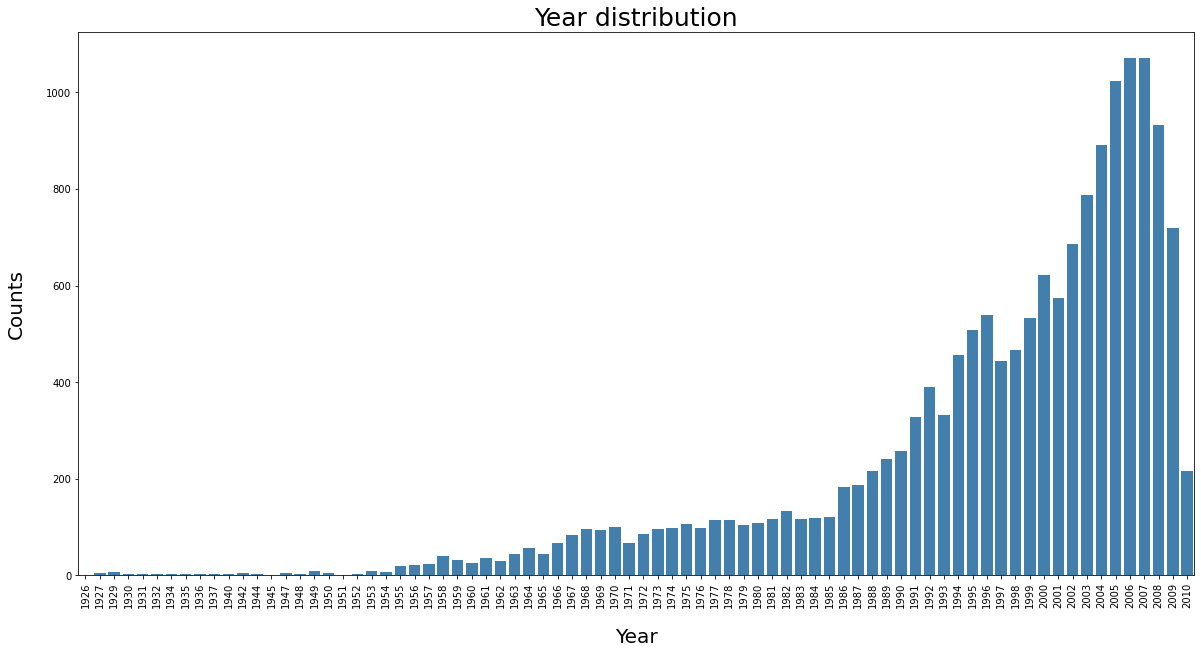

In [10]:
#Plot distribution by year
df_song1 = df_song1[df_song1["year"]!=0]
df = df_song1.groupby('year').count()


plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plot = sns.barplot(x=df.index, y=df.artist_latitude, color='#3182bd')
plot.set_title('Year distribution', fontsize= 25 )
plot.set_ylabel('Counts', fontsize=20, labelpad=20)
plot.set_xlabel('Year', fontsize=20, labelpad=20)
plt.savefig('../docs/images/year_distr.png')
plt.show()

In [11]:
artistDensityMap(df_song1)

amamaa


In [12]:
#Train the model (using data from part 2 which is larger)
LDA = LatentDirichletAllocation(10, learning_method='batch', random_state=42)
vectorizer, X = get_LDA_vectorizer_features(df_song2)
%time X_transform = LDA.fit_transform(X)

CPU times: user 3min, sys: 480 ms, total: 3min 1s
Wall time: 3min 1s


In [13]:
show_top_topic(LDA, vectorizer, top=10)

,0,1,2,3,4,5,6,7,8,9
Topic 0,reggae,world,dub,world music,dancehall,roots reggae,chill-out,celtic,new age,rock steady
Topic 1,experimental,post rock,electronica,ambient,new wave,synthpop,art rock,noise,intelligent dance music,psychedelic
Topic 2,latin,spanish,christian,christian rock,salsa,ccm,latin pop,gospel,spain,male vocalist
Topic 3,heavy metal,death metal,metal,black metal,thrash metal,doom metal,progressive metal,grindcore,metalcore,industrial
Topic 4,rock,indie,pop,indie rock,alternative,acoustic,singer-songwriter,alternative rock,folk,indie pop
Topic 5,pop rock,soft rock,ballad,classic rock,disco,blues-rock,soul,country rock,chanson,europop
Topic 6,punk,hard rock,hardcore,ska,grunge,emo,hardcore punk,80s,pop punk,progressive rock
Topic 7,rap,hip hop,funk,urban,club,united states,underground hip hop,american,underground,gangster rap
Topic 8,jazz,blues,smooth jazz,easy listening,instrumental,fusion,jazz funk,contemporary jazz,classical,piano
Topic 9,electronic,house,techno,trance,electro,breakbeat,downtempo,deep house,tech house,progressive house


In [14]:
#Add the super genre to the DataFrame
df_song1["genre"] = np.argmax(LDA.transform(get_LDA_features(df_song1, vectorizer)), axis=1)
df_song2["genre"] = np.argmax(X_transform, axis=1)

In [43]:
showMapWithTime(selectGenre(df_song1,3))

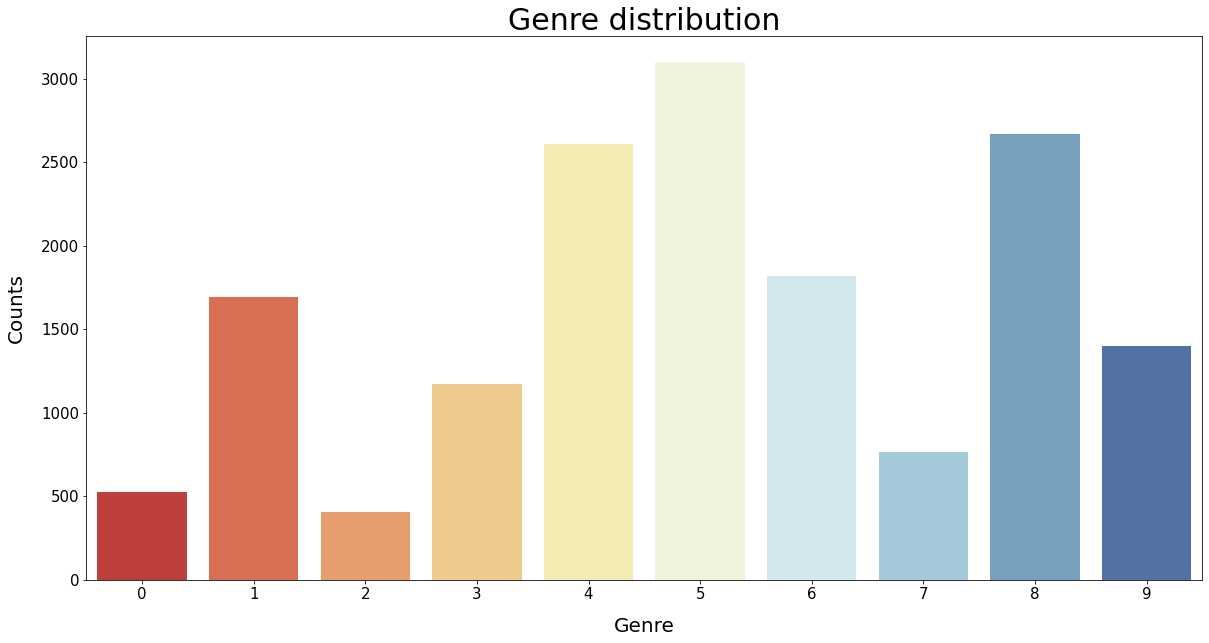

In [16]:
#Plot distribution by year
df = df_song1[['genre', 'year']].groupby('genre').count()

plt.figure(figsize=(20,10))
plot = sns.barplot(x=df.index, y=df.year, order=df.index, palette='RdYlBu')
plot.set_title('Genre distribution', fontsize=30)
plot.set_ylabel('Counts', fontsize=20, labelpad=15)
plot.set_xlabel('Genre', fontsize=20, labelpad=15)
plot.xaxis.axes.tick_params(labelsize=15)
plot.yaxis.axes.tick_params(labelsize=15)
plt.savefig('../docs/images/genre_distr.png')
plt.show()

In [44]:
showMapWithTimeAndWeight(extendsData(selectGenre(df_song1, 3)), htmlFilename='outputMap.html')

In [18]:
df_song2.columns

Index(['index', 'artist_hotttnesss', 'artist_name', 'artist_terms',
       'artist_terms_weight', 'loudness', 'song_hotttnesss', 'tempo', 'year',
       'title', 'X_mean', 'X_std', 'X_skew', 'X_kurtosis', 'X_median',
       'artist_terms_weight_', 'genre'],
      dtype='object')

In [19]:
df_song2.head()

,index,artist_hotttnesss,artist_name,artist_terms,artist_terms_weight,loudness,song_hotttnesss,tempo,year,title,X_mean,X_std,X_skew,X_kurtosis,X_median,artist_terms_weight_,genre
0,13413,0.587810,The Verve,"[british pop, noise pop, space rock, dream pop...","[1.0, 1.0, 0.9693157995281735, 0.9683766771439...",-6.151,1.0,85.460,1997,Bitter Sweet Symphony,"[48.714512500000026, 27.432468269230753, 23.89...","[5.385839622765557, 31.465559166011364, 33.421...","[-3.048178323802161, 0.0717475954852985, 0.559...","[13.500431457614312, 1.674667359881516, 0.0021...","[50.488, 27.8445, 19.1595, -6.2985, 2.435, -20...","[100.0, 100.0, 96.93157995281734, 96.837667714...",4
1,19198,0.712535,B.o.B,"[dirty south rap, hard rock, hip hop, rap, roc...","[1.0, 0.9061623028905438, 0.8599617732846392, ...",-5.388,1.0,104.038,2010,Nothin' On You [feat. Bruno Mars] (Album Version),"[48.41074739829709, -12.06464616840115, 17.372...","[6.691138802231206, 42.21960984347845, 32.9969...","[-3.720057776466325, -0.3625414825772898, 0.04...","[17.175629236988655, 0.758764358785672, 0.6304...","[49.86, -9.871, 17.918, 1.006, 8.819, -9.359, ...","[100.0, 90.61623028905437, 85.99617732846392, ...",7
2,34479,0.558476,Dido,"[singer-songwriter, rock, pop, alternative, in...","[1.0, 0.9126629523307435, 0.8752240038034773, ...",-6.836,1.0,85.055,2003,White Flag,"[45.13986604774532, -7.744330238726798, -1.091...","[6.482160900165754, 49.65701056169309, 47.6395...","[-1.6350018783009663, 0.7249464044283234, 0.06...","[4.473796424903421, 2.436975142020482, -0.4815...","[46.5655, -10.5475, -3.4865, -11.8105000000000...","[100.0, 91.26629523307435, 87.52240038034773, ...",4
3,2797,0.718561,Plain White T's,"[emo, rock, pop, indie, punk pop, emo pop, gru...","[1.0, 0.9153054189381935, 0.8284883808824768, ...",-9.047,1.0,104.378,2005,Hey There Delilah,"[46.61102729885057, -48.76368678160924, -39.45...","[3.283745958628116, 50.61906900457968, 34.0734...","[-5.727257064529277, 0.48308994360270463, -0.1...","[67.45477960938881, 0.5749912137608937, -0.370...","[47.1575, -51.2025, -37.799, -34.4175000000000...","[100.0, 91.53054189381935, 82.84883808824767, ...",4
4,4208,0.566249,Counting Crows,"[ballad, american trad rock, soundtrack, acous...","[1.0, 0.8889454294750114, 0.8649109572832718, ...",-5.526,1.0,141.612,1991,Mr. Jones,"[48.50247536231889, -25.008901449275353, 32.73...","[5.244971235385474, 39.87776816515396, 34.9143...","[-3.233417789036039, 0.10717340243280711, -0.0...","[19.90957381734907, 2.0785463049119697, 1.2435...","[49.741, -25.875, 32.406, 3.621, 14.104, -16.8...","[100.0, 88.89454294750114, 86.49109572832718, ...",4


In [48]:
segmTimb178 =  df_song2[["genre","X_mean"]][(df_song2["genre"] == 0) | (df_song2["genre"] == 3) ]
X_content178 = segmTimb178['X_mean'].tolist()#.astype(list).tolist()
X_content178 = np.array(X_content178)
pca = PCA(n_components = 2).fit_transform(X_content178)

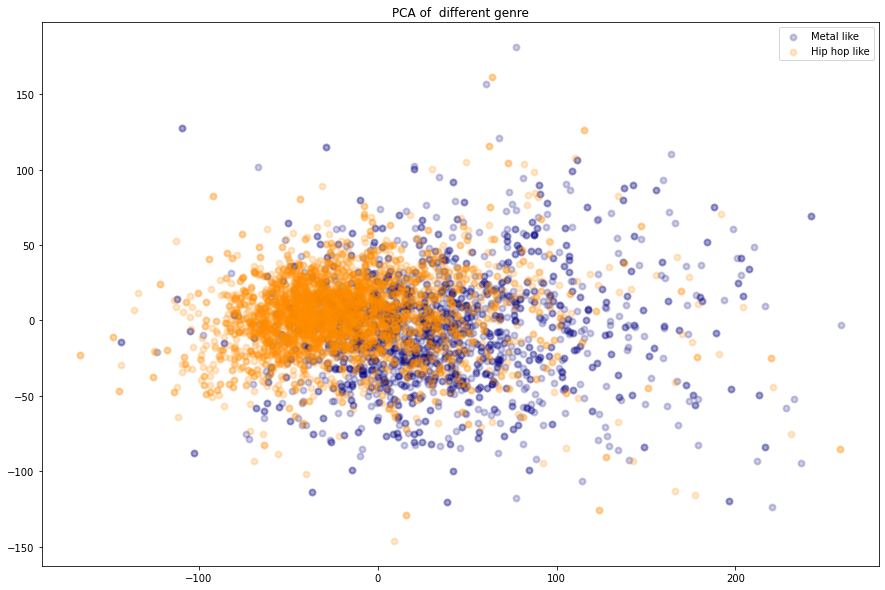

In [49]:
plt.figure(figsize=(15,10))
colors = ['navy', 'darkorange']
names = ["Metal like", "Hip hop like"]
y = segmTimb178["genre"]
lw = 2

for color, i, names in zip(colors, [0, 3], names):
    plt.scatter(pca[y == i, 0], pca[y == i, 1], color=color, alpha=.2, lw=lw, label = names)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of  different genre')
plt.savefig('../docs/images/PCA_17.png')
plt.show()

In [24]:
%time song_2d = TSNE(n_components=2, n_iter=1000, random_state=42).fit_transform(X_transform)

CPU times: user 8min 20s, sys: 1min 20s, total: 9min 40s
Wall time: 1min 51s


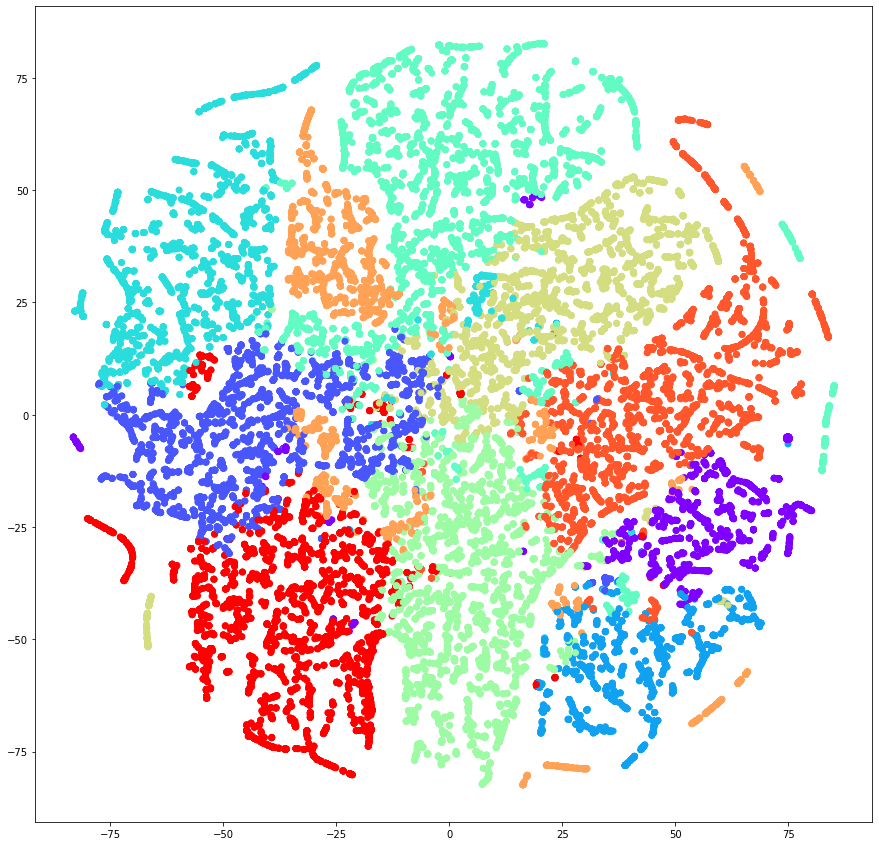

In [25]:
colors = matplotlib.cm.rainbow(np.linspace(0, 1, 10))
plot2d_matplotlib(song_2d, df_song2["genre"].apply(lambda g: colors[g]).values)

In [26]:
X_content = get_features(df_song2)
X_pred = X_content[:10000]
X_train = X_content[10000:]
Y_train = X_transform[10000:]

genre_pred = df_song2["genre"].values[:10000]
infos_pred = df_song2.apply(build_info, axis=1).values[:10000]
urls_pred = df_song2.preview_url.values[:10000]
%time content_song_2d = TSNE(n_components=2, n_iter=1000, random_state=42).fit_transform(X_pred)

AttributeError: 'DataFrame' object has no attribute 'preview_url'

In [47]:
df_song2.tail()

,index,artist_hotttnesss,artist_name,artist_terms,artist_terms_weight,loudness,song_hotttnesss,tempo,year,title,X_mean,X_std,X_skew,X_kurtosis,X_median,artist_terms_weight_,genre
39191,4894,0.159717,Nybbl,"[post rock, breakbeat, intelligent dance music...","[1.0, 0.9593189859054189, 0.9409284550288509, ...",-7.375,0.187895,130.060,0,Such Grand Ideas,"[46.774625468164835, 17.017346441947574, 36.35...","[6.868086678527789, 68.8048465634212, 43.75648...","[-2.5555575223481592, -0.8247478788262864, -0....","[10.876973475504341, 2.5000989658625183, 0.200...","[48.613, 29.185499999999998, 39.8995, -2.63550...","[100.0, 95.93189859054189, 94.0928455028851, 9...",9
39192,3346,0.159717,Nybbl,"[post rock, breakbeat, intelligent dance music...","[1.0, 0.9593189859054189, 0.9409284550288509, ...",-7.375,0.187895,130.060,0,Such Grand Ideas,"[46.774625468164835, 17.017346441947574, 36.35...","[6.868086678527789, 68.8048465634212, 43.75648...","[-2.5555575223481592, -0.8247478788262864, -0....","[10.876973475504341, 2.5000989658625183, 0.200...","[48.613, 29.185499999999998, 39.8995, -2.63550...","[100.0, 95.93189859054189, 94.0928455028851, 9...",9
39193,10727,0.285415,Freddy Fader meets Locana,"[techno, trance, electronic, jumpstyle, euro-h...","[1.0, 0.914948321784413, 0.7342016945334934, 0...",-8.348,0.187843,140.017,0,Bom_ Bom - Suenan (Big Room Mix),"[44.929481521739135, 39.1046027173913, -0.8560...","[5.858108426034834, 45.9203146373563, 39.87305...","[-1.583665021820557, -1.1033415336954229, 0.08...","[2.78412962782345, 8.51373198525671, -0.118385...","[46.682500000000005, 37.548, -1.093, 22.4965, ...","[100.0, 91.4948321784413, 73.42016945334933, 7...",9
39194,24425,0.285415,Freddy Fader meets Locana,"[techno, trance, electronic, jumpstyle, euro-h...","[1.0, 0.914948321784413, 0.7342016945334934, 0...",-8.348,0.187843,140.017,0,Bom_ Bom - Suenan (Big Room Mix),"[44.929481521739135, 39.1046027173913, -0.8560...","[5.858108426034834, 45.9203146373563, 39.87305...","[-1.583665021820557, -1.1033415336954229, 0.08...","[2.78412962782345, 8.51373198525671, -0.118385...","[46.682500000000005, 37.548, -1.093, 22.4965, ...","[100.0, 91.4948321784413, 73.42016945334933, 7...",9
39195,12495,0.303772,Stevedore,"[synthpop, blues, country, country pop, guitar...","[1.0, 0.9366167759843431, 0.7462548815604855, ...",-8.035,0.187778,126.966,0,Tiny Thoughts,"[45.96773684210527, -13.205756578947343, -1.67...","[4.728114871348724, 43.10224005871279, 38.0517...","[-2.0443276772734844, 0.5673734369891866, 1.12...","[8.195216249192969, 0.7421091434326965, 2.0852...","[47.2275, -19.5275, -7.391, -2.182000000000000...","[100.0, 93.66167759843431, 74.62548815604855, ...",8
